# Make MRL and abundance predictions with DaniO5P
This notebook illustrates how to make predictions on an arbitrary sequence with DaniO5P.

DaniO5P is made of two components: a length model and a convolutional neural network (CNN) model. Full predictions are calculated by summing the outputs of these two models.

Make sure you have downloaded the CNN model weights before running this notebook.

In [1]:
import pickle
import sys

import numpy
import matplotlib
from matplotlib import pyplot

utils_dir = 'utils'
sys.path.append(utils_dir)
import seq_utils
import cnn_vgg

In [2]:
# Model outputs are log2 MRLs then Δlog2 Xs for each timepoint
timepoint_list = [2, 4, 6, 10]
log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
delta_log2_x_cols = [f'Δlog2_X_{t}hpf' for t in timepoint_list]
model_outputs = log2_mrl_cols + delta_log2_x_cols

# Maximum input sequence length
max_seq_len = 238

In [3]:
# Sequence to predict
# Don't exceed the maximum length specified above
seq_to_predict = 'GCTCGTCCCGCCGCTGCCTCTCTCTCTCTCTCTCTCCCTCCCTCTCTCAGGTAGGGCCTCAGAGCGAAG'

## Length model prediction

In [4]:
# Functions to make predictions from sequence length

def predict_from_seq_len_single_output(x, a):
    """
    Predicts a single output given a sequence length.

    Parameters
    ----------
    x : int
        The sequence length to predict for.
    a : list
        The coefficients of the polynomial model.

    Returns
    -------
    y_pred : float
        The predicted value.

    """
    y_pred = 0
    for i in range(3):
        y_pred += a[i]*(x**i)
    return y_pred

def predict_from_seq_len(seq, length_model_params):
    """
    Predicts all outputs given a sequence length.

    Parameters
    ----------
    seq : str
        The sequence to predict for.
    length_model_params : dict
        The model parameters.

    Returns
    -------
    y_pred : numpy.array
        The predicted values.

    """
    y_pred = []
    for m in model_outputs:
        p = length_model_params[m]
        y_pred.append(predict_from_seq_len_single_output(len(seq), p))

    return numpy.array(y_pred)

In [5]:
# Load model parameters
# length_model_params is a dictionary where the keys are each of the model output names
# and the values are the parameters of the polynomial model for that output
with open('length_model/poly_2_params.pickle', 'rb') as handle:
    length_model_params = pickle.load(handle)

length_model_params

{'log2_MRL_2hpf': array([ 6.99646357e+00, -4.12189270e-02,  9.22431636e-05]),
 'log2_MRL_4hpf': array([ 7.82440520e+00, -5.16798613e-02,  1.25737802e-04]),
 'log2_MRL_6hpf': array([ 5.92862326e+00, -3.04479625e-02,  7.26491485e-05]),
 'log2_MRL_10hpf': array([ 8.70662460e+00, -6.32159808e-02,  1.35898562e-04]),
 'Δlog2_X_2hpf': array([-4.45053072e-01, -2.22101446e-02,  6.71997889e-05]),
 'Δlog2_X_4hpf': array([-1.68929673e+00,  1.64039512e-02, -5.14284521e-05]),
 'Δlog2_X_6hpf': array([ 1.62845273e-01, -2.35574427e-02,  5.39651336e-05]),
 'Δlog2_X_10hpf': array([-3.47516908e+00,  2.60757058e-02, -6.23094056e-05])}

In [6]:
# Make predictions for the given sequence
length_model_preds = predict_from_seq_len(seq_to_predict, length_model_params)
length_model_preds

array([ 4.59152731,  4.85713244,  4.17359645,  4.99173498, -1.65761486,
       -0.80227496, -1.20569028, -1.97260047])

## Sequence (CNN) model predictions

In [7]:
# Load model weights
model_path = 'cnn/models_cnn_vgg/model_avg.h5'
model = cnn_vgg.load_model(model_path)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, 4)]    0           []                               
                                                                                                  
 model (Functional)             (None, 8)            5866062     ['input_11[0][0]']               
                                                                                                  
 model_1 (Functional)           (None, 8)            5866062     ['input_11[0][0]']               
                                                                                                  
 model_2 (Functional)           (None, 8)            5866062     ['input_11[0][0]']               
                                                                                           

In [8]:
# Generate predictions
# First, we need to one-hot encode the sequence
# The CNN model needs a fixed input length of max_seq_len, so the sequence
# is placed on the right of a max_seq_len x 4 array and the rest is filled
# with zeros. Output is 1 x max_seq_len x 4
# Note that several sequences can be given to the model at once. In this case,
# provide a list of sequences to one_hot_encode. The output will have dimensions
# len(sequences) x max_seq_len x 4.
seq_onehot = seq_utils.one_hot_encode(
    [seq_to_predict],
    max_seq_len=max_seq_len, padding='right', mask_val=0,
)

# Actually compute predictions
# Here we only have one sequence, so we take the first element of the output
cnn_preds = model.predict(seq_onehot)[0]

cnn_preds

array([-2.355495  , -1.6185169 , -1.1422846 , -0.7431985 ,  0.65880126,
       -0.27230197, -0.11180959, -0.07343087], dtype=float32)

## Plot predictions
Here we plot the length model and full model predictions together, so we can see to what extent sequence features regulate translation and abundance.

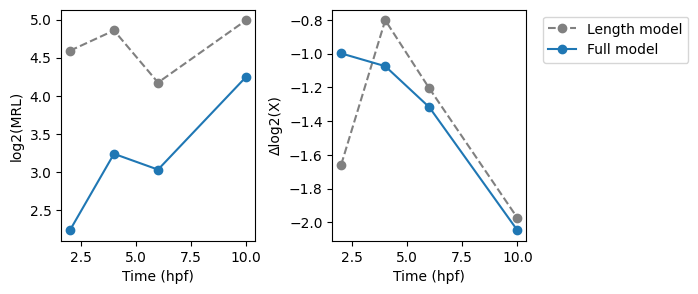

In [9]:
# First, plot log2(MRL) and Δlog2(X)

fig, axes = pyplot.subplots(1, 2, figsize=(6, 3))
fig.subplots_adjust(wspace=0.4)

ax = axes[0]
ax.plot(
    timepoint_list,
    length_model_preds[:4],
    marker='o',
    color='grey', linestyle='--',
    label='Length model',
)
ax.plot(
    timepoint_list,
    length_model_preds[:4] + cnn_preds[:4],
    marker='o',
    label='Full model',
)
ax.set_xlabel('Time (hpf)')
ax.set_ylabel('log2(MRL)')
# ax.legend()

ax = axes[1]
ax.plot(
    timepoint_list,
    length_model_preds[4:],
    marker='o',
    color='grey', linestyle='--',
    label='Length model',
)
ax.plot(
    timepoint_list,
    length_model_preds[4:] + cnn_preds[4:],
    marker='o',
    label='Full model',
)
ax.set_ylabel('Δlog2(X)')
ax.set_xlabel('Time (hpf)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


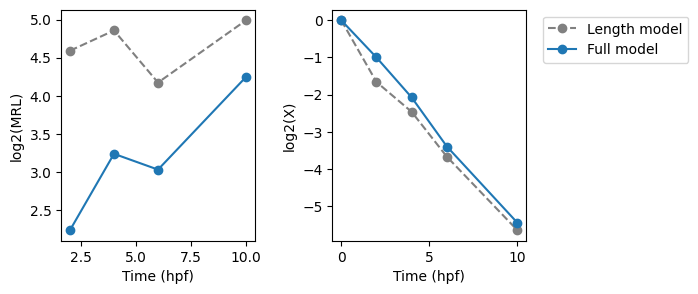

In [10]:
# Plot log2(X) (estimated abundance) instead of Δlog2(X)
# As a reminder, we define log2(X) at time zero to be zero.
# For every successive time point, log2(X) is the cumulative
# sum of Δlog2(X) from time zero to that time point.

fig, axes = pyplot.subplots(1, 2, figsize=(6, 3))
fig.subplots_adjust(wspace=0.4)

ax = axes[0]
ax.plot(
    timepoint_list,
    length_model_preds[:4],
    marker='o',
    color='grey', linestyle='--',
    label='Length model',
)
ax.plot(
    timepoint_list,
    length_model_preds[:4] + cnn_preds[:4],
    marker='o',
    label='Full model',
)
ax.set_xlabel('Time (hpf)')
ax.set_ylabel('log2(MRL)')
# ax.legend()

ax = axes[1]
ax.plot(
    [0] + timepoint_list,
    numpy.concatenate(([0], length_model_preds[4:].cumsum())),
    marker='o',
    color='grey', linestyle='--',
    label='Length model',
)
ax.plot(
    [0] + timepoint_list,
    numpy.concatenate(([0], (length_model_preds[4:] + cnn_preds[4:]).cumsum())),
    marker='o',
    label='Full model',
)
ax.set_ylabel('log2(X)')
ax.set_xlabel('Time (hpf)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
